# Encoder Decoder

## Set up

In [1]:
import os
import numpy as np
import random
import torch

print(f'PyTorch version: {torch.__version__}')

from torch.utils.data import DataLoader

from utils.PytorchUtils import PytorchUtils
from utils.Visualisation import Visualisation
from utils.DatasetUtils import DatasetUtils
from utils.ImageGenerator import ImageGenerator

from src.InitModel import InitModel

from dataset_creation.DataManagerNpz import DataManagerNpz
from dataset_creation.StrokeImageDataset import StrokeImageDataset


PyTorch version: 2.1.0+cu121


## Selecting the device on which the notebook will be running

In [2]:
device = PytorchUtils.device_section()
print(f'Using device: {device}')

Using device: cuda


In [3]:
WIDTH, HEIGHT = 128, 128
STROKE_SIZE = 3
IMAGE_FACTOR = 1.1
EPOCHS: int = 55
BATCH_SIZE: int = 128

MODEL = "conv-variational-embed"
CONV_ARCHITECTURE = [1, 32, 16, 8]
LINEAR_ARCHITECTURE = [WIDTH * HEIGHT, WIDTH * HEIGHT * 3 // 4]
DROPOUT = 0.1
BATCH_NORM = True

LR = 0.0005

RL=0.4
KL=0.6

LEN_SUBSET = 20000
VALID_TEST_SUBSET = 5000

In [4]:
CONV_MODEL_DATA = "conv" in MODEL

## Loading npz data

In [5]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    data.append(data_class)
    class_size[class_name] = len(data_class)

print(class_size[classes[0]])
print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

3
loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


## Dataset creation

In [6]:
data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

In [8]:
training_set = StrokeImageDataset(
        data=shuffled_training_data[:LEN_SUBSET], 
        labels=shuffled_training_labels[:LEN_SUBSET],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:VALID_TEST_SUBSET], 
        labels=shuffled_validation_labels[:VALID_TEST_SUBSET],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:VALID_TEST_SUBSET], 
        labels=shuffled_test_labels[:VALID_TEST_SUBSET],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

In [9]:
print(f'training set distribution :\n{Visualisation.dataset_distribution(classes, training_set)}')
print(f'validation set distribution :\n{Visualisation.dataset_distribution(classes, validation_set)}')
print(f'test set distribution :\n{Visualisation.dataset_distribution(classes, test_set)}')

training set distribution :
{0: 2511, 1: 2658, 2: 2470, 3: 2479, 4: 2502, 5: 2497, 6: 2538, 7: 2345}
validation set distribution :
{0: 625, 1: 610, 2: 585, 3: 656, 4: 658, 5: 635, 6: 635, 7: 596}
test set distribution :
{0: 635, 1: 595, 2: 616, 3: 610, 4: 656, 5: 649, 6: 640, 7: 599}


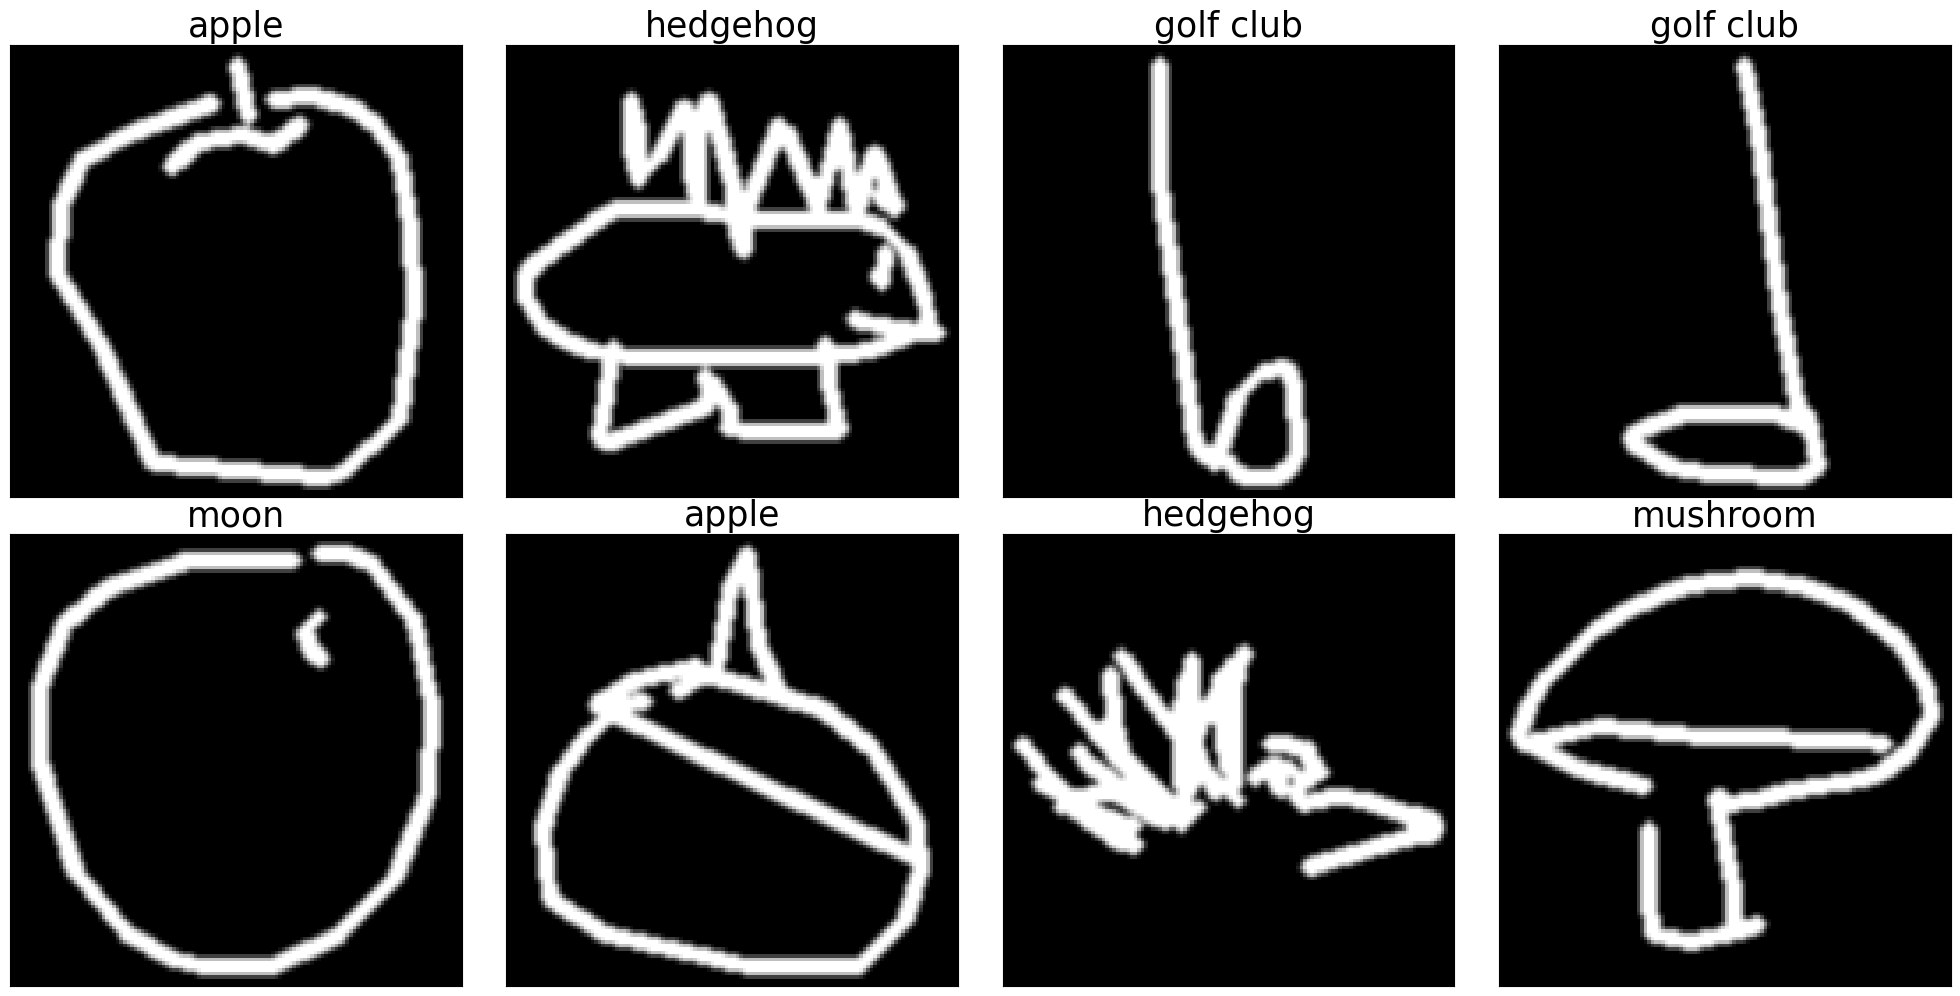

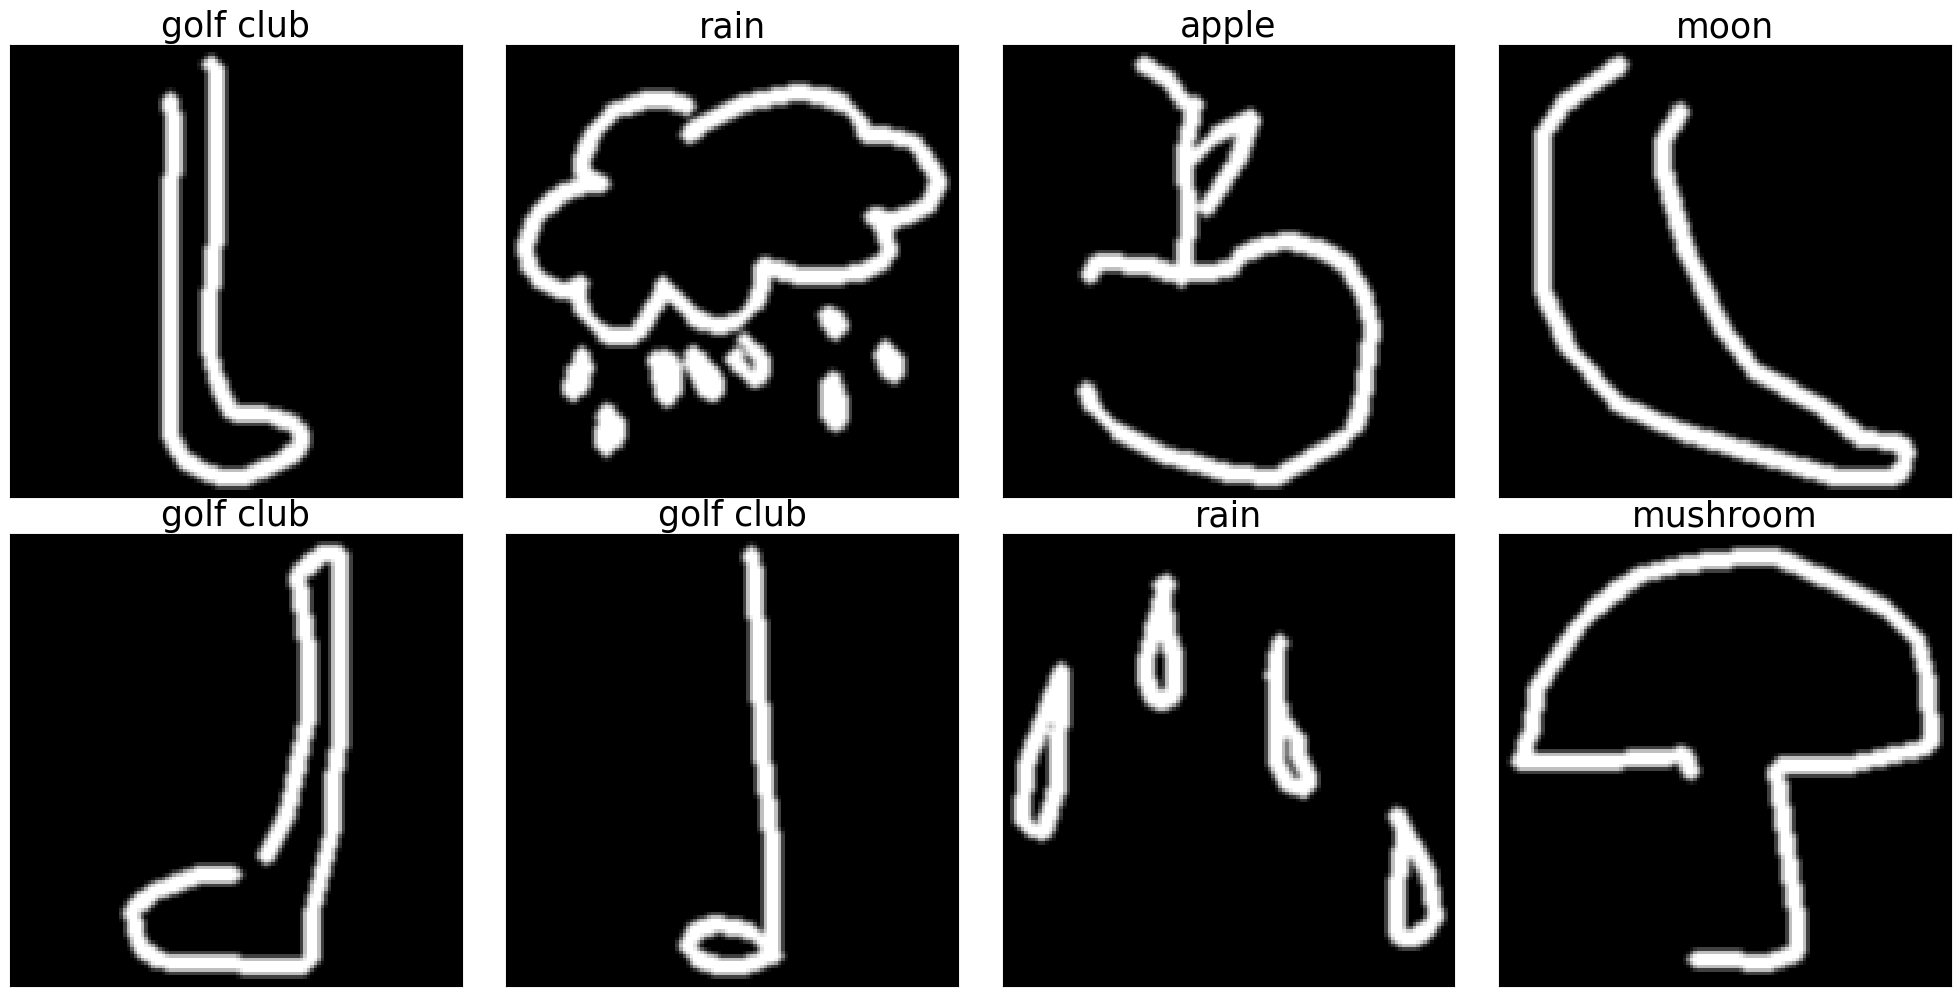

In [10]:
Visualisation.plot_random_images(training_set, classes)

Visualisation.plot_random_images(training_set, classes)

## Autoencoder class

In [11]:
autoencoder_model, is_embed_model = InitModel.init_model(
            MODEL,
            device, 
            WIDTH, HEIGHT, classes,  
            CONV_ARCHITECTURE, LINEAR_ARCHITECTURE,  DROPOUT, BATCH_NORM, RL, KL,
            verbose=True)

criterion, optimizer = InitModel.create_criterion_optimizer(MODEL, autoencoder_model, LR)

Chosen model :  <class 'src.conv_variational_autoencoder_embed.ConvVariationalAutoencoderEmbed'>


In [12]:
InitModel.print_model_characteristics(autoencoder_model)

Class :  ConvVariationalAutoencoderEmbed
encoder :
Sequential(
  (encoder_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_0): ELU(alpha=1.0)
  (encoder_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_0): Dropout(p=0.0, inplace=False)
  (encoder_batchnorm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_1): ELU(alpha=1.0)
  (encoder_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_1): Dropout(p=0.0, inplace=False)
  (encoder_batchnorm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
latent space
Flatten(start_dim=1, end_dim=-1)
Linear(in_features=8192, out_features=16384, bias=True)
Linear(i

### Train the model

In [13]:
# Check if path exists for weight, else path not and will train

path = os.path.join(PytorchUtils.WEIGHTS_FOLDER, PytorchUtils.give_file_name(autoencoder_model, EPOCHS))

if not os.path.exists(path):
    path = None

autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, optimizer, criterion, EPOCHS, path=path)

Attempting to load weights from : weights/ConvVariationalAutoencoderEmbed_128x128_55_epochs.pt
loading weights from : weights/ConvVariationalAutoencoderEmbed_128x128_55_epochs.pt
attempting to train 55 epochs but 55 epochs already done -> no training performed


In [14]:
#PytorchUtils.save_checkpoint(autoencoder_model, 25, autoencoder_model.metrics, autoencoder_model.losses, optimizer)

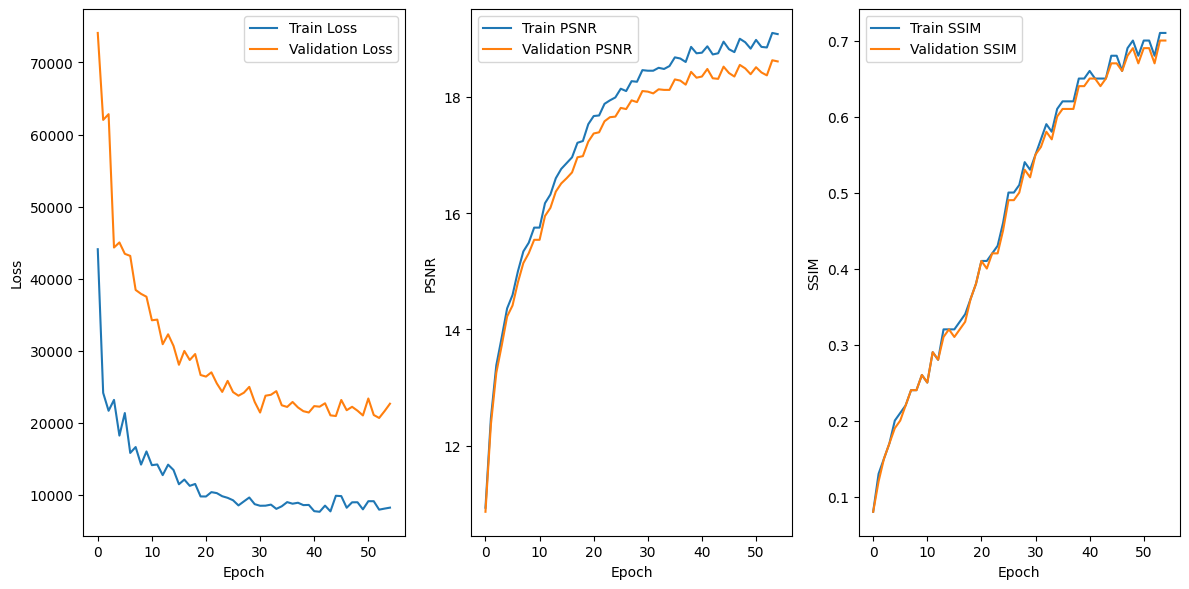

In [15]:
autoencoder_model.plot_psnr_ssim()

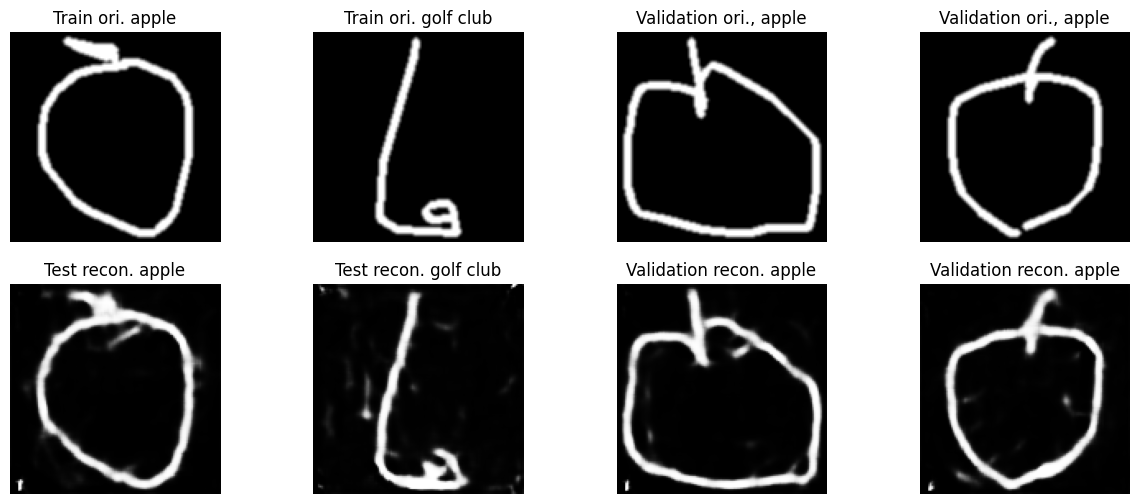

In [16]:
autoencoder_model.show_images(training_set, test_set)

In [17]:
CHECK_BACTH_SIZE = 80

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [18]:
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

Lowest PSNR index: 10|12.442286378658753, Lowest SSIM index: 7|0.45149672187026096


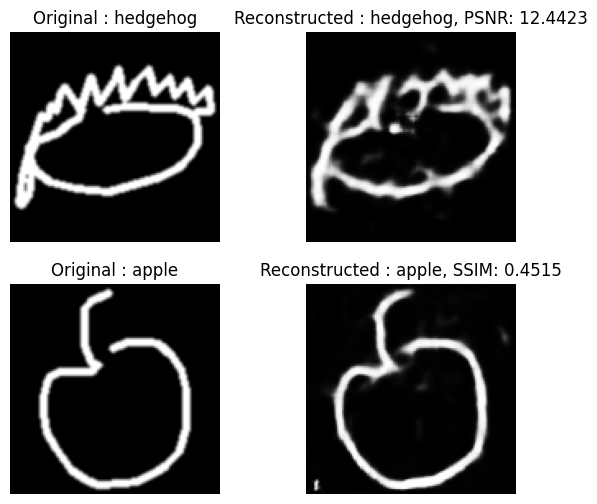

In [19]:
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Show latent space

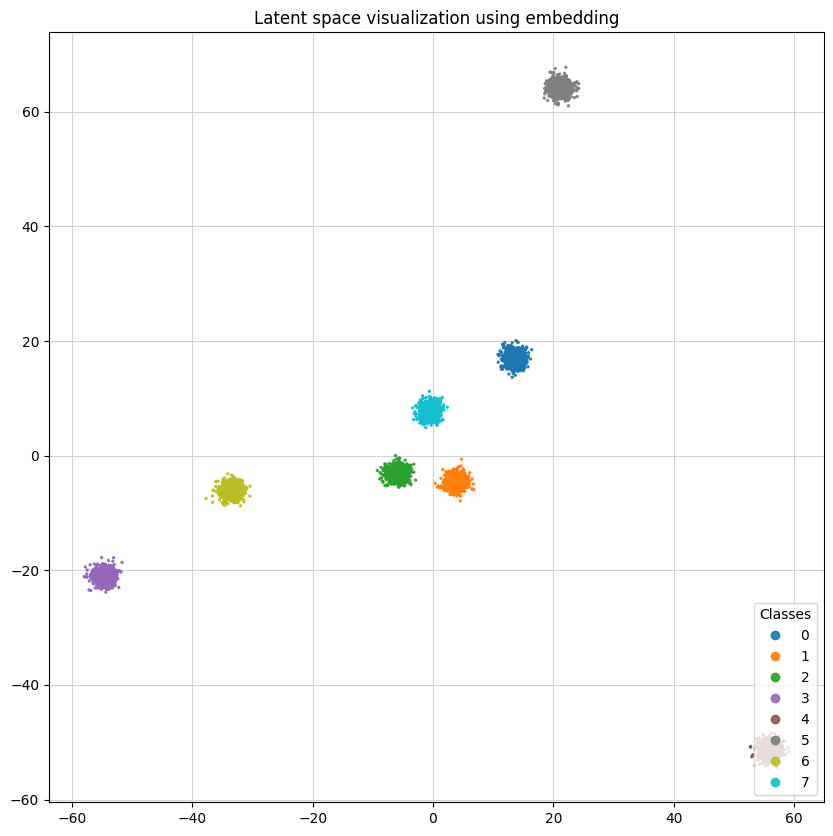

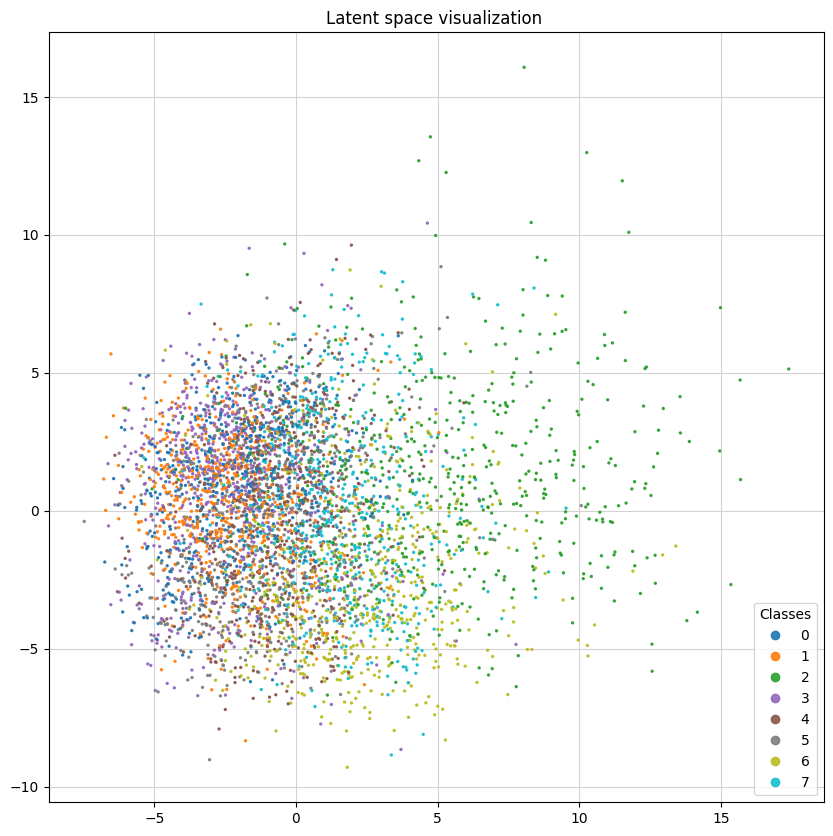

In [20]:
Visualisation.latent_space_visualization(autoencoder_model, validation_loaded_set, use_embedding=True)
Visualisation.latent_space_visualization(autoencoder_model, validation_loaded_set, use_embedding=False)

## Generating images

In [21]:
image_generator = ImageGenerator(classes, device, autoencoder_model)

### Generating the mean vectors

Class apple range of mean encoded embed vector: [-3.5668873283693108,3.253881628035739]
Class apple range of mean encoded vector: [-3.5668873283693108,3.253881628035739]
Class golf club range of mean encoded embed vector: [-3.860789108581342,3.3753561164939914]
Class golf club range of mean encoded vector: [-3.860789108581342,3.3753561164939914]
Class hedgehog range of mean encoded embed vector: [-3.474736498676331,4.011339036607549]
Class hedgehog range of mean encoded vector: [-3.474736498676331,4.011339036607549]
Class moon range of mean encoded embed vector: [-3.716924341756906,3.546691860340929]
Class moon range of mean encoded vector: [-3.716924341756906,3.546691860340929]
Class mushroom range of mean encoded embed vector: [-3.234935724096809,3.453271893288592]
Class mushroom range of mean encoded vector: [-3.234935724096809,3.453271893288592]
Class rain range of mean encoded embed vector: [-3.7024049084330732,3.3746302049065475]
Class rain range of mean encoded vector: [-3.70240

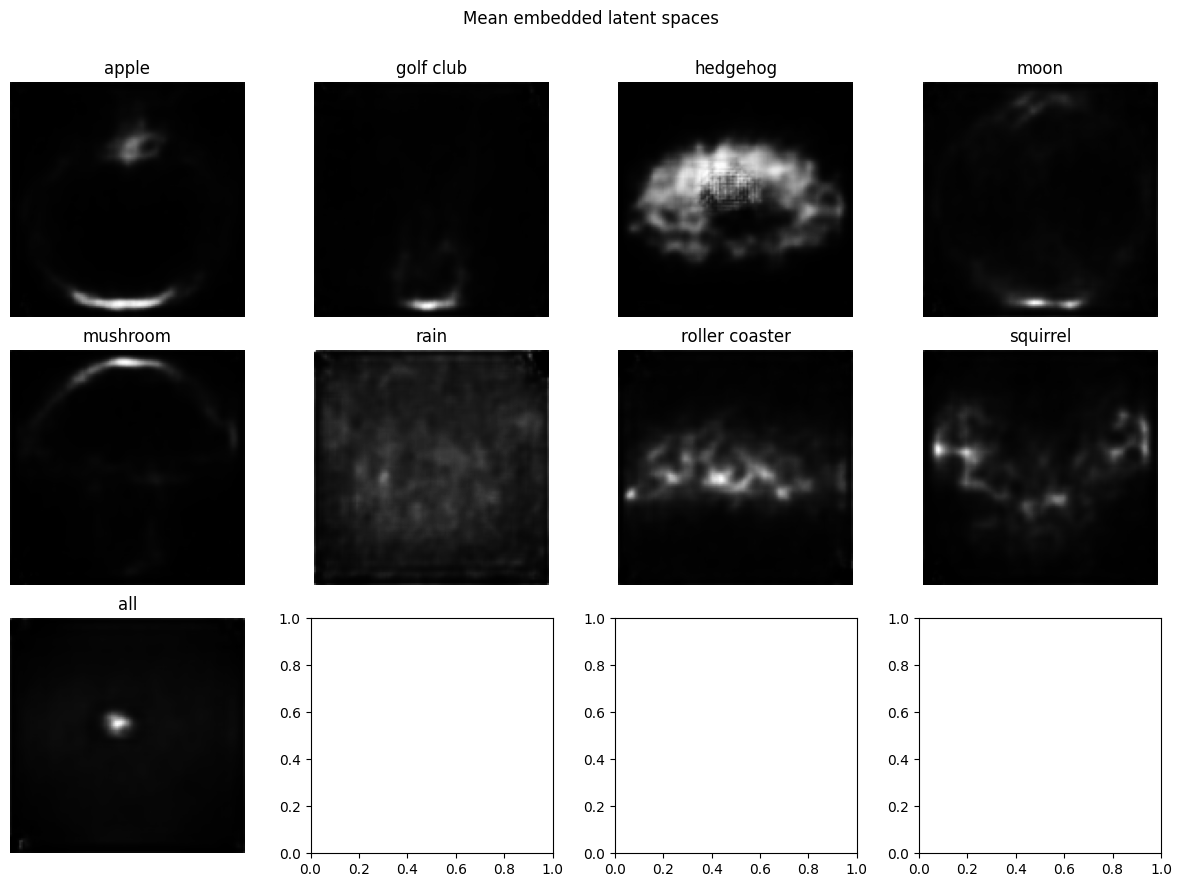

In [22]:
mean_encoded_information = image_generator.generate_mean_encoded_information(training_loaded_set)

has_embedding = "mean_before" in mean_encoded_information[0].keys()

print(f'has embedding: {has_embedding}')

mean_vectors1 = []
for i in range(len(mean_encoded_information)):
    mean_vectors1.append(mean_encoded_information[i]['mean'])

image_generator.show_generated_images_per_mean_vectors(
        mean_vectors1, 
        title=("Mean embedded latent spaces" if has_embedding else "Mean latent spaces"),
        image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

### Generating a bit the mean vector by the variance

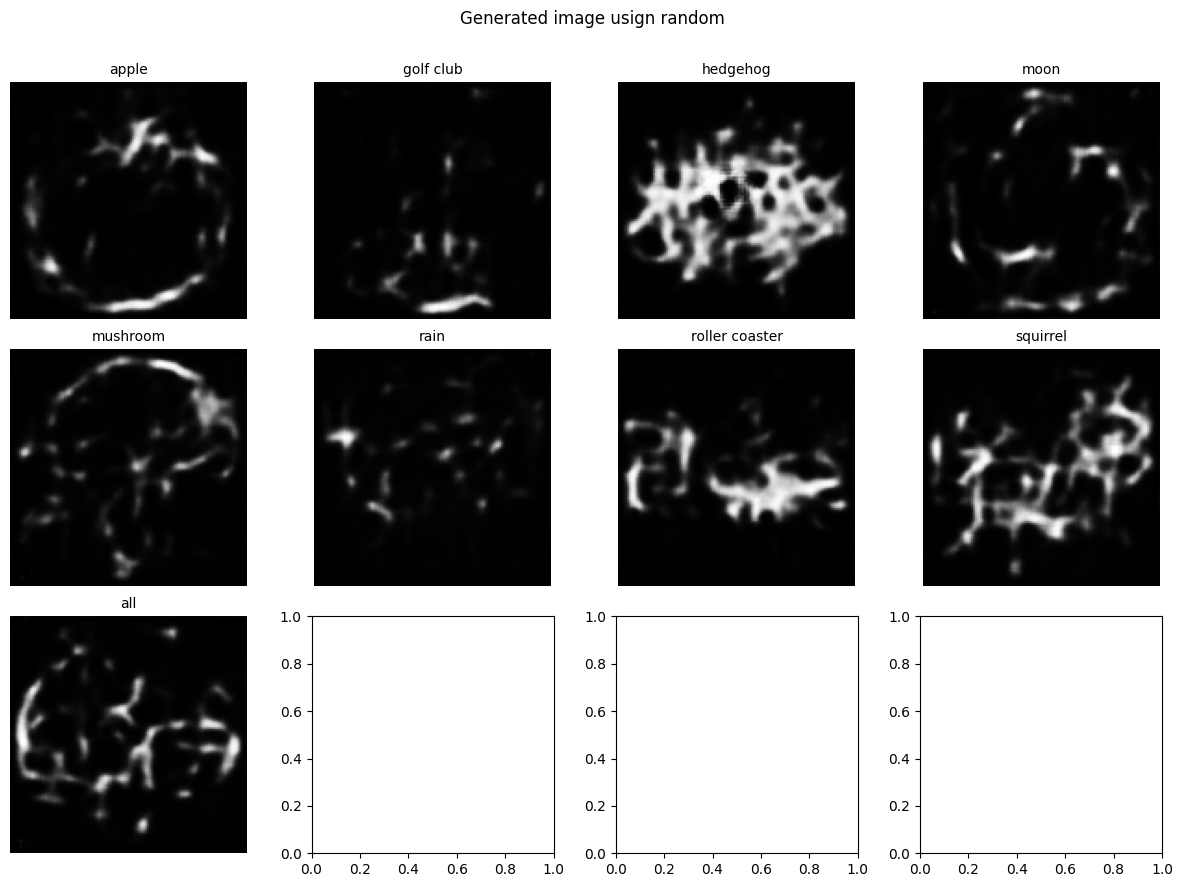

In [23]:
noised_encoded_vectors = []
titles = []

for i in range(len(mean_encoded_information)):
    alternative = image_generator.create_alternative_version(mean_encoded_information[i]['mean'], 
                                                             mean_encoded_information[i]['var'], 1)

    noised_encoded_vectors.append(alternative)

    if i < len(classes):
        titles.append(classes[i])
    else:
        titles.append("all")
    

image_generator.show_generated_images_per_vector(
    noised_encoded_vectors, 
    titles=titles, 
    title="Generated image usign random", 
    image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

### Generation of an image to which we add the embeddings of the other classes

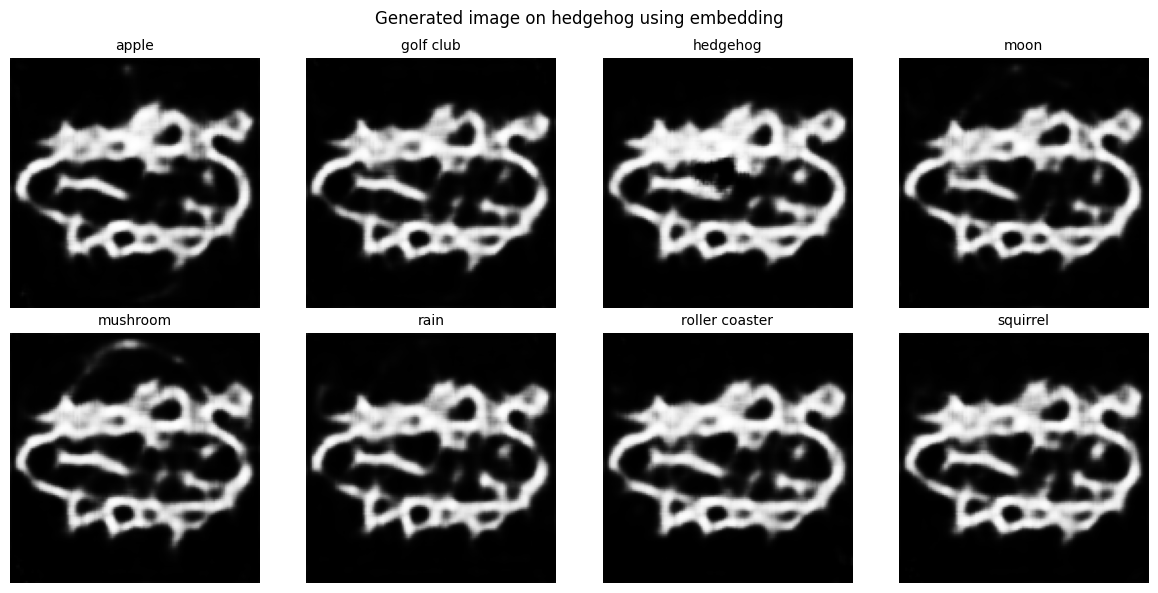

In [24]:
if is_embed_model:

    image, label = training_set[0]

    latent_spaces = []
    labels = []

    with torch.no_grad():
        image = PytorchUtils.numpy_to_tensor(image, device).unsqueeze(0)
        label = torch.tensor(label).to(device).unsqueeze(0)

        pack = autoencoder_model(image, label)

        encoded_before = PytorchUtils.tensor_to_numpy(pack["encoded_before"])

        for i in range(len(classes)):
            latent_spaces.append(encoded_before)
            labels.append(i)

        image_generator.show_generated_images_per_vector(
            latent_spaces, 
            labels=labels,
            titles=classes, 
            title=f"Generated image on {classes[label]} using embedding", 
            image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

# Interpolation

### z_embed class (n) => z_embed' class (n)

In [25]:
def add(tuple, a, b, c):
    a += tuple[0]
    b += tuple[1]
    c += tuple[2]

n_images = 3
interpolation = 8

label_1 = 0
label_2 = 1
label_3 = 2

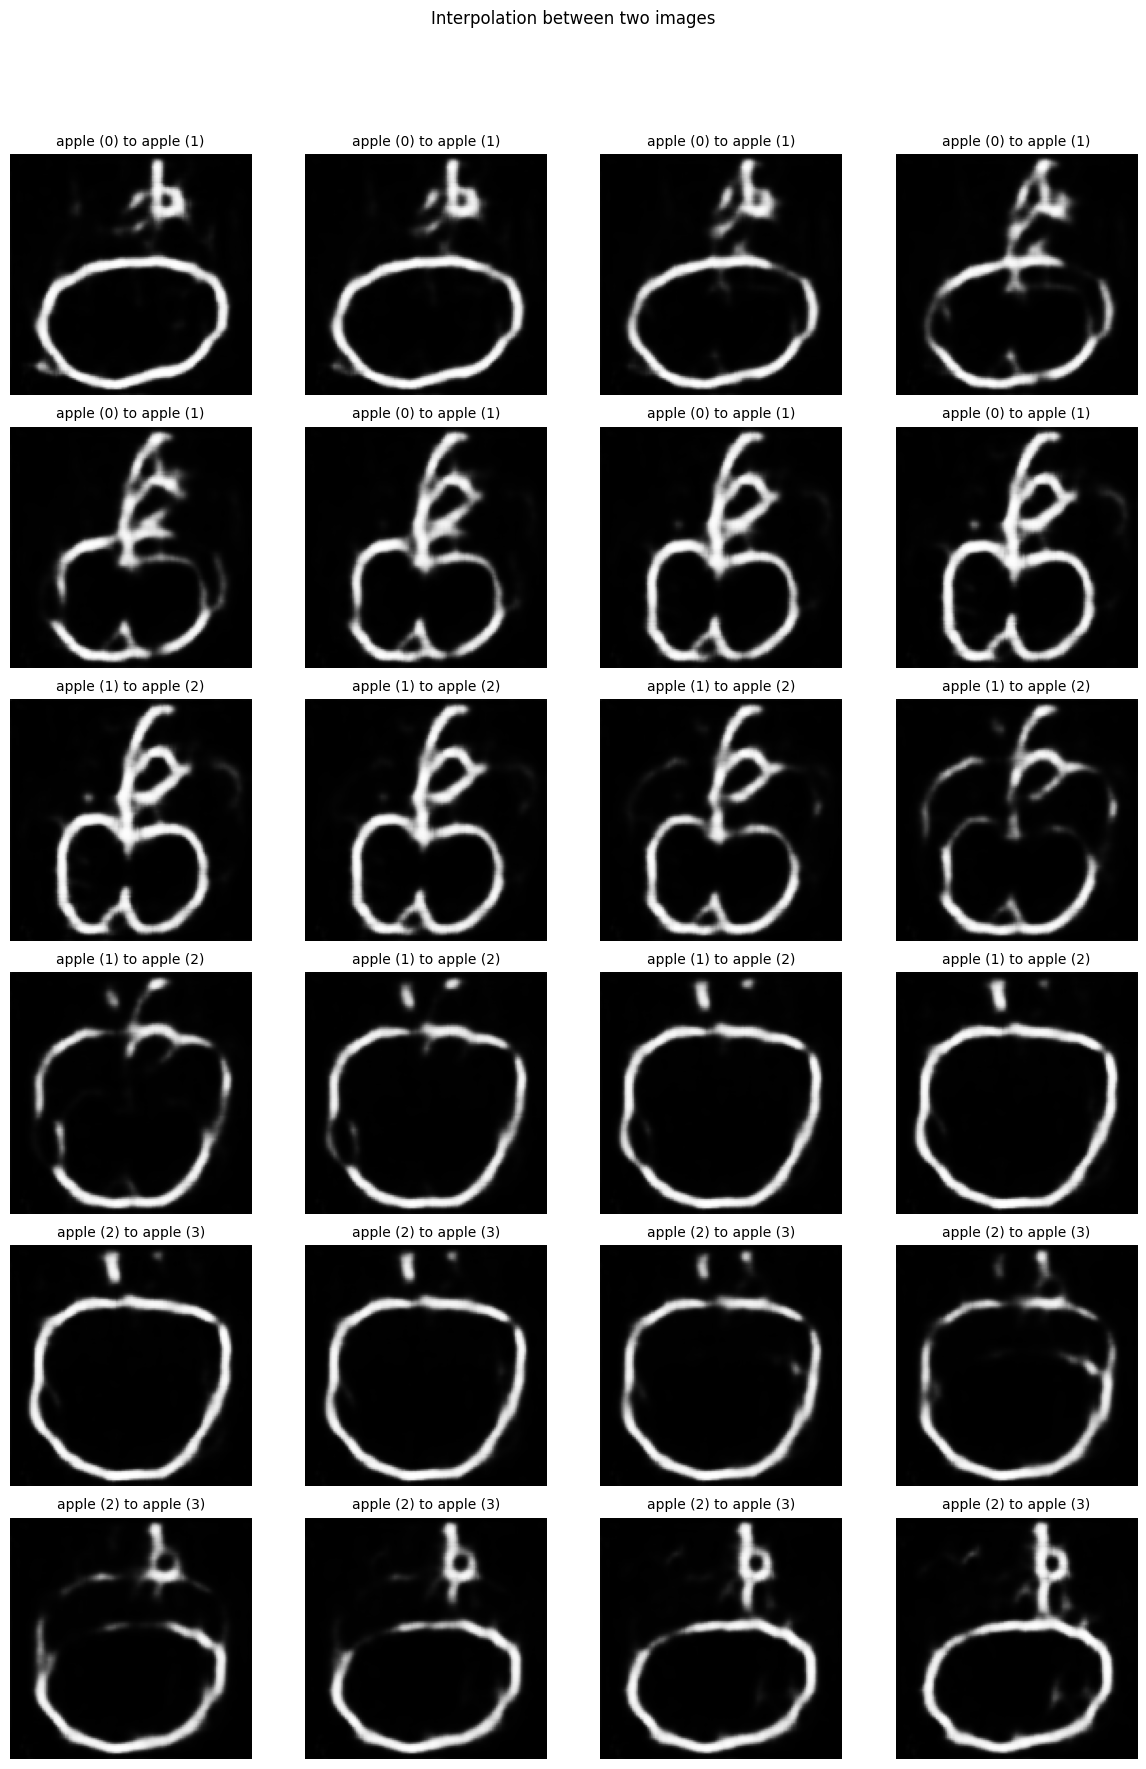

In [26]:
images, image_labels, image_indices = DatasetUtils.get_n_first_for_label(training_set, label_1, n_images)
images.append(images[0])
image_labels.append(image_labels[0])
image_indices.append(image_indices[0])

encoded = []
titles = []

with torch.no_grad():
    for i in range(len(images)):
        if i < len(images) - 1:
            for j in range(interpolation):
                titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")


        pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
        encoded.append(pack['encoded'])

    images = image_generator.interpolate_vectors(encoded, 
                                                interpolation_number=interpolation, 
                                                save_path="results/embed_n_to_n/", 
                                                image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

    image_generator.show_generated_images(images, 
                                        title="Interpolation between two images",
                                        titles=titles)

### z_embed class (n) => z_embed' class (m, n != m)

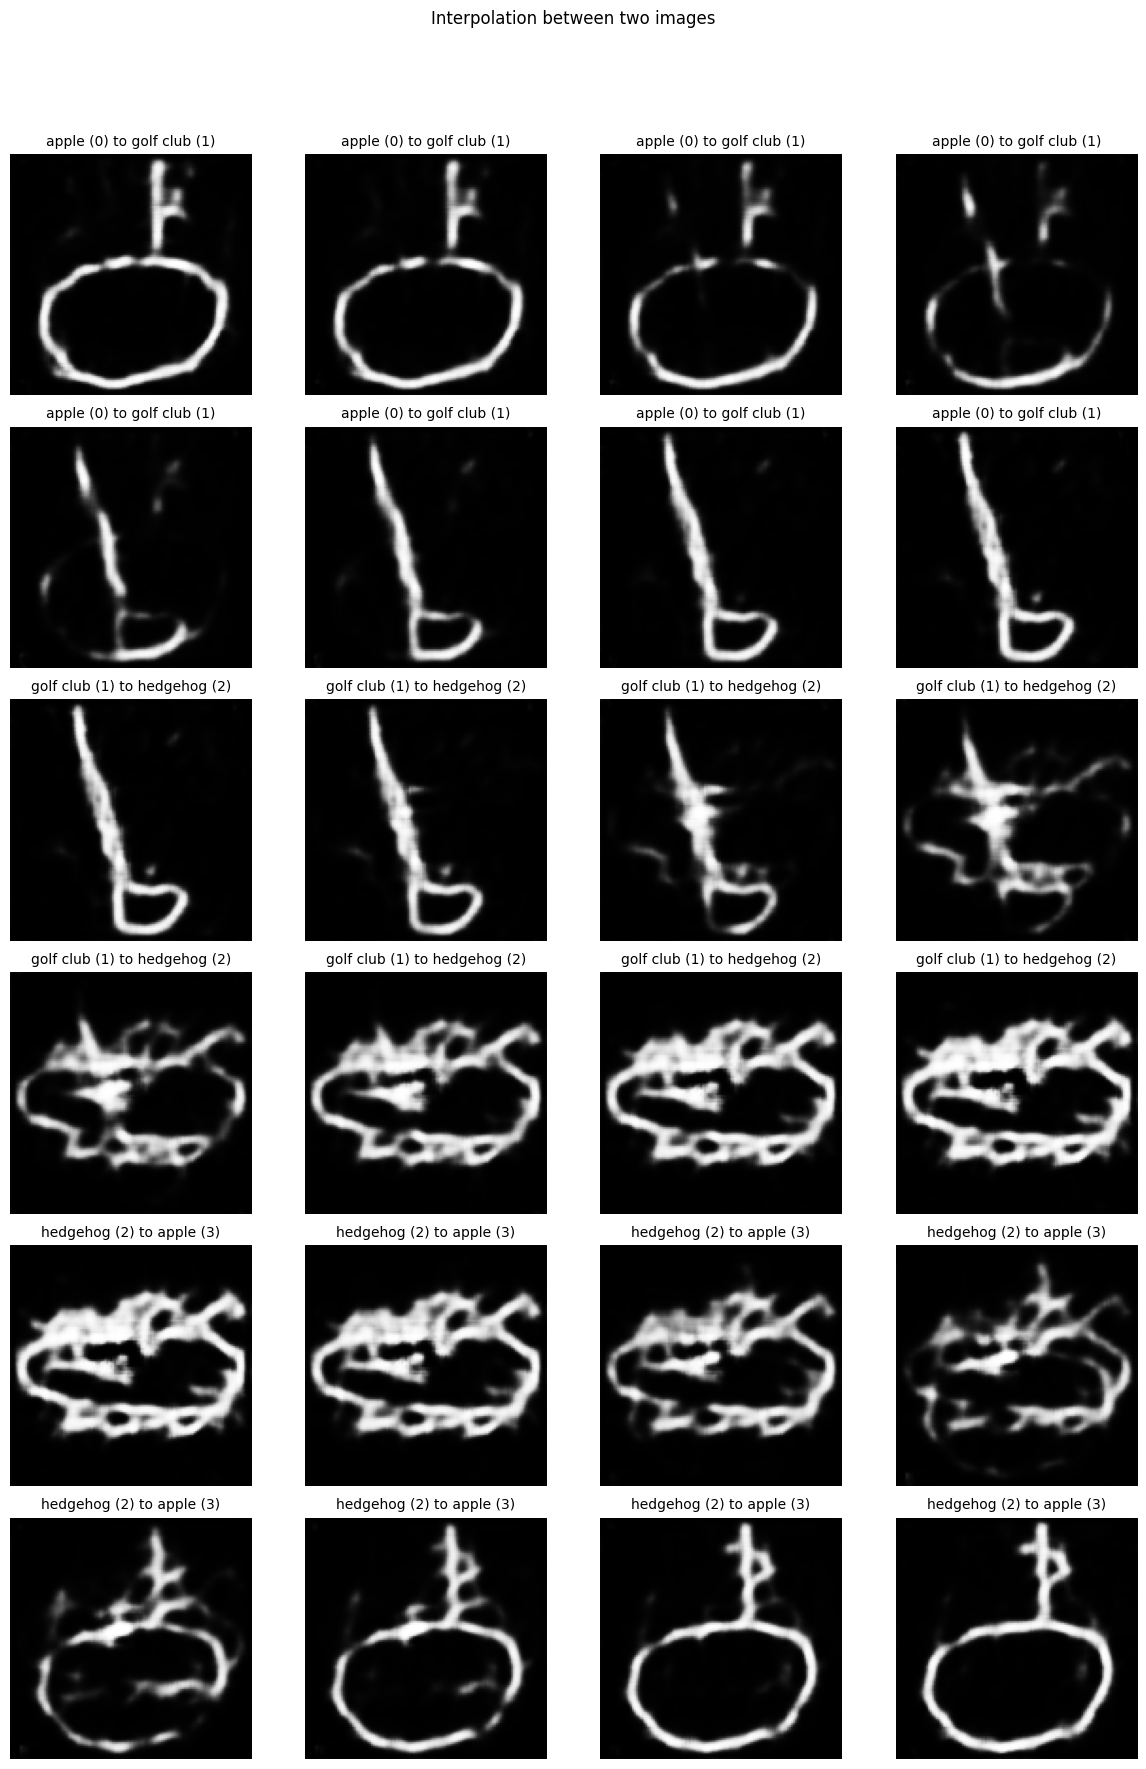

In [27]:
images, image_labels, image_indices = [], [], []

add(DatasetUtils.get_n_first_for_label(training_set, label_1, 1), images, image_labels, image_indices)
add(DatasetUtils.get_n_first_for_label(training_set, label_2, 1), images, image_labels, image_indices)
add(DatasetUtils.get_n_first_for_label(training_set, label_3, 1), images, image_labels, image_indices)

images.append(images[0])
image_labels.append(image_labels[0])
image_indices.append(image_indices[0])

encoded = []
titles = []

with torch.no_grad():
    for i in range(len(images)):
        if i < len(images) - 1:
            for j in range(interpolation):
                titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")


        pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
        encoded.append(pack['encoded'])

    images = image_generator.interpolate_vectors(encoded, 
                                                interpolation_number=interpolation, 
                                                save_path="results/embed_n_to_m/", 
                                                image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)))

    image_generator.show_generated_images(images, 
                                        title="Interpolation between two images",
                                        titles=titles)

### z (class n) + embed_class m => z' (class m, n != m) + embed_class n

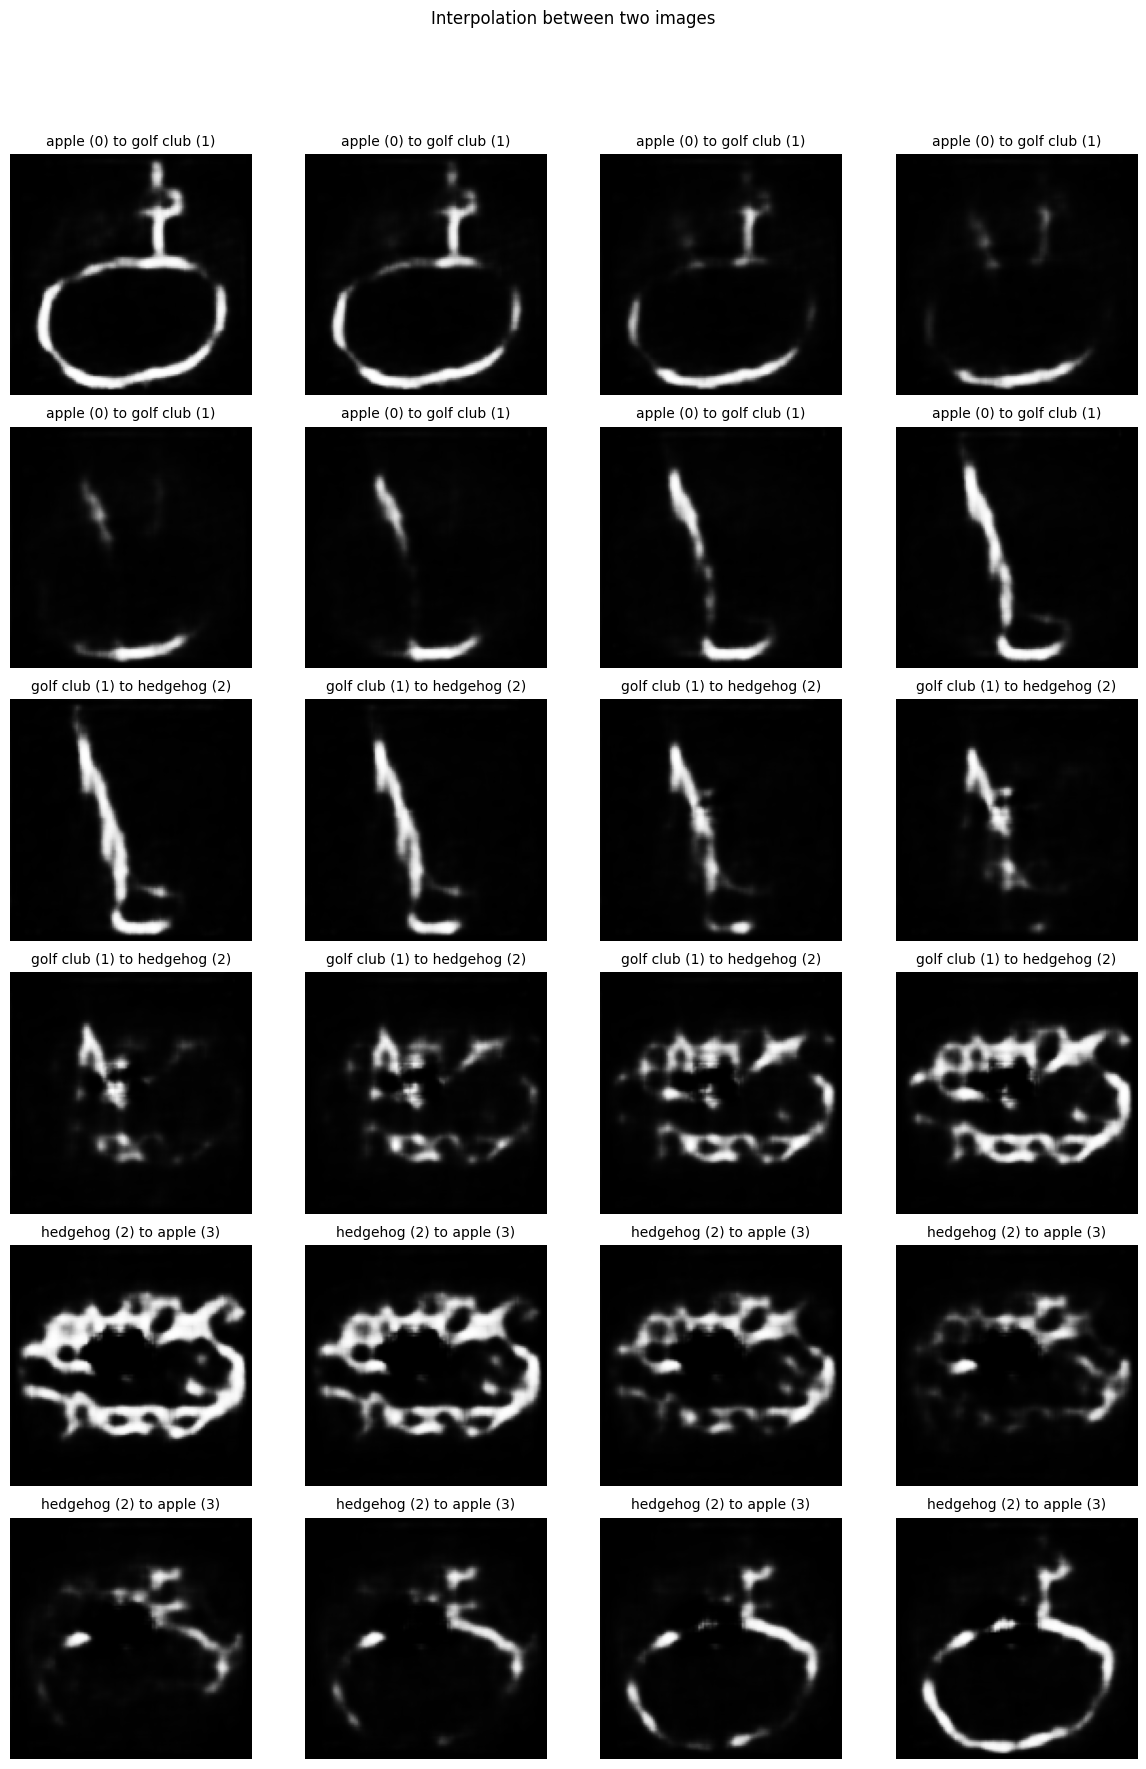

In [28]:
if is_embed_model:
    images, image_labels, image_indices = [], [], []

    add(DatasetUtils.get_n_first_for_label(training_set, label_1, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_2, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_3, 1), images, image_labels, image_indices)

    images.append(images[0])
    image_labels.append(image_labels[0])
    image_indices.append(image_indices[0])

    encoded = []
    titles = []

    with torch.no_grad():
        for i in range(len(images)):
            if i < len(images) - 1:
                for j in range(interpolation):
                    titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")

            pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
            encoded.append(pack['encoded'])

        images = image_generator.interpolate_vectors(encoded, 
                                                    interpolation_number=interpolation, 
                                                    save_path="results/n_to_m_embed_before/", 
                                                    image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)),
                                                    labels=image_labels)

        image_generator.show_generated_images(images, 
                                            title="Interpolation between two images",
                                            titles=titles)

### z (class n) + embed_class m => z' (class m, n != m) + embed_class m

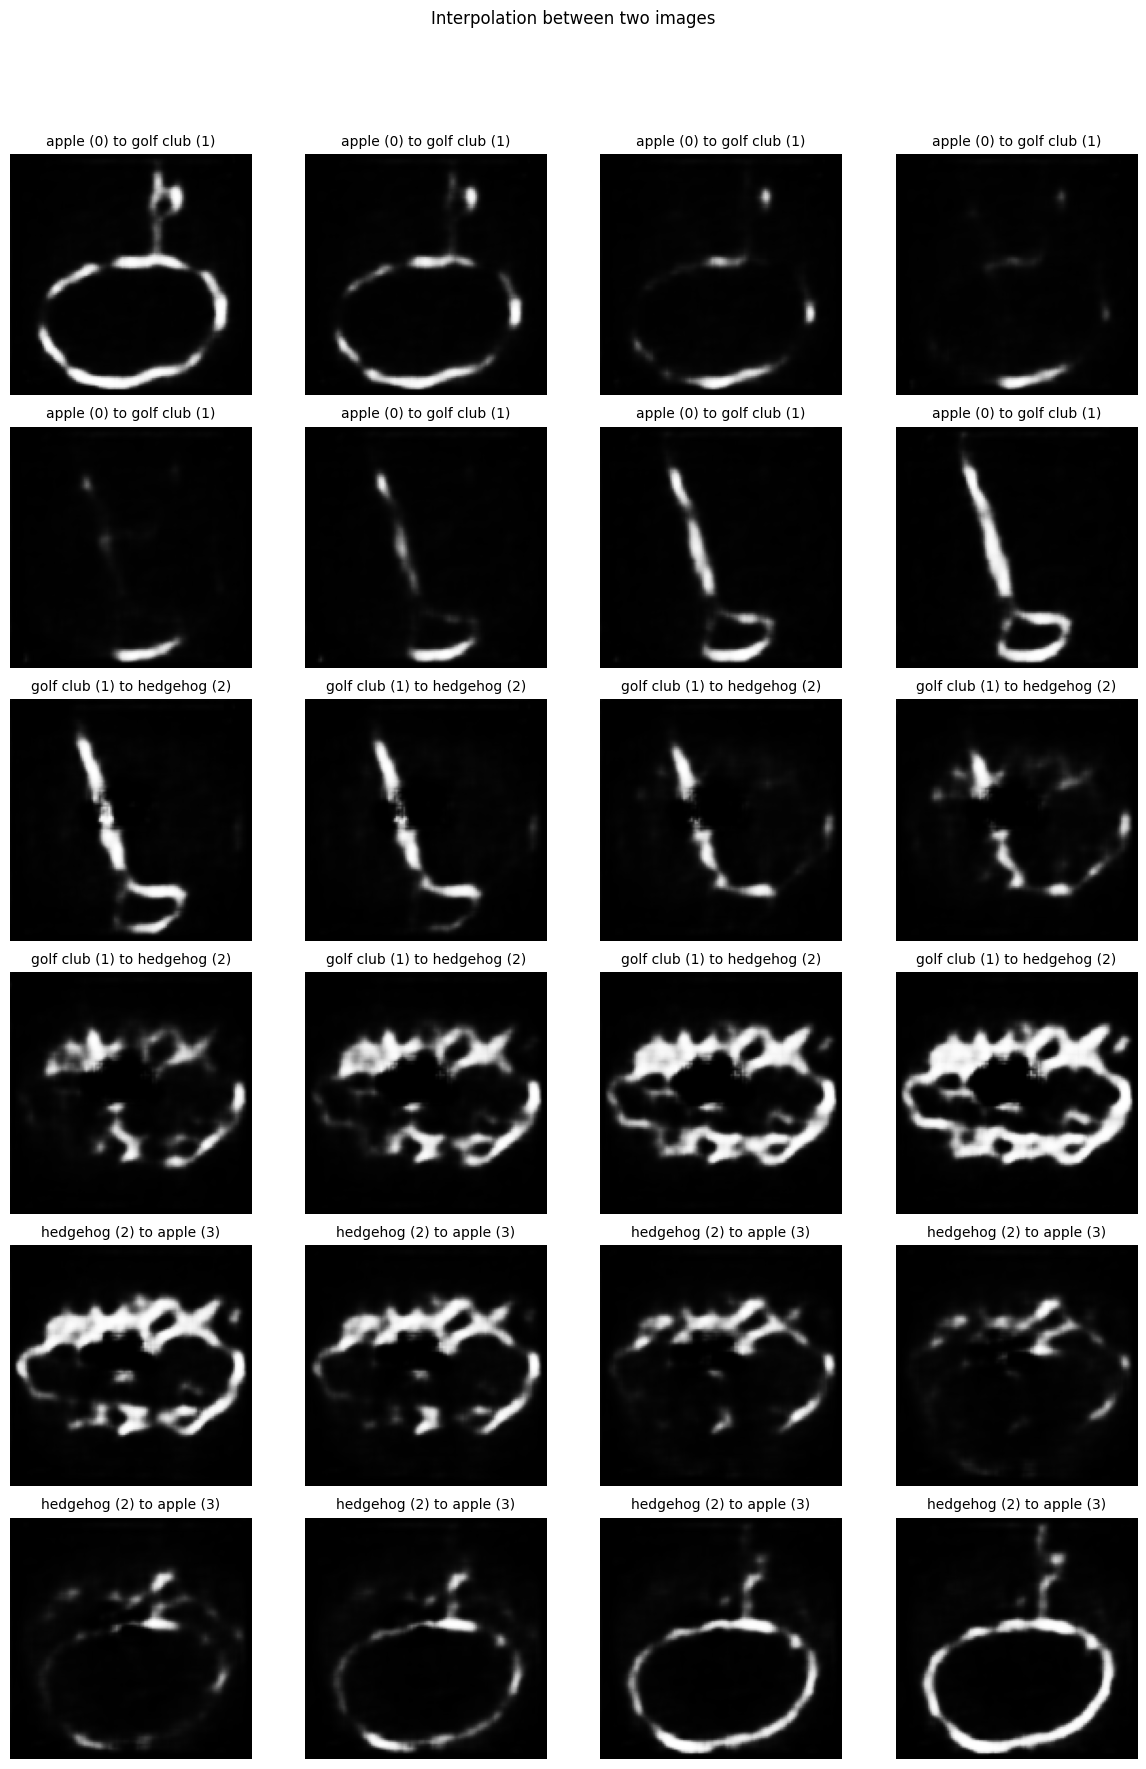

In [29]:
if is_embed_model:

    images, image_labels, image_indices = [], [], []

    add(DatasetUtils.get_n_first_for_label(training_set, label_1, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_2, 1), images, image_labels, image_indices)
    add(DatasetUtils.get_n_first_for_label(training_set, label_3, 1), images, image_labels, image_indices)

    images.append(images[0])
    image_labels.append(image_labels[0])
    image_indices.append(image_indices[0])

    encoded = []
    titles = []

    with torch.no_grad():
        for i in range(len(images)):
            if i < len(images) - 1:
                for j in range(interpolation):
                    titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")

            pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
            encoded.append(pack['encoded'])

        # move labels by one
        del image_labels[0]

        images = image_generator.interpolate_vectors(encoded, 
                                                    interpolation_number=interpolation, 
                                                    save_path="results/n_to_m_embed_after/", 
                                                    image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)),
                                                    labels=image_labels)

        image_generator.show_generated_images(images, 
                                            title="Interpolation between two images",
                                            titles=titles)

### z (class n) + embed_class m => z' (class m) + embed_class n, n !=m

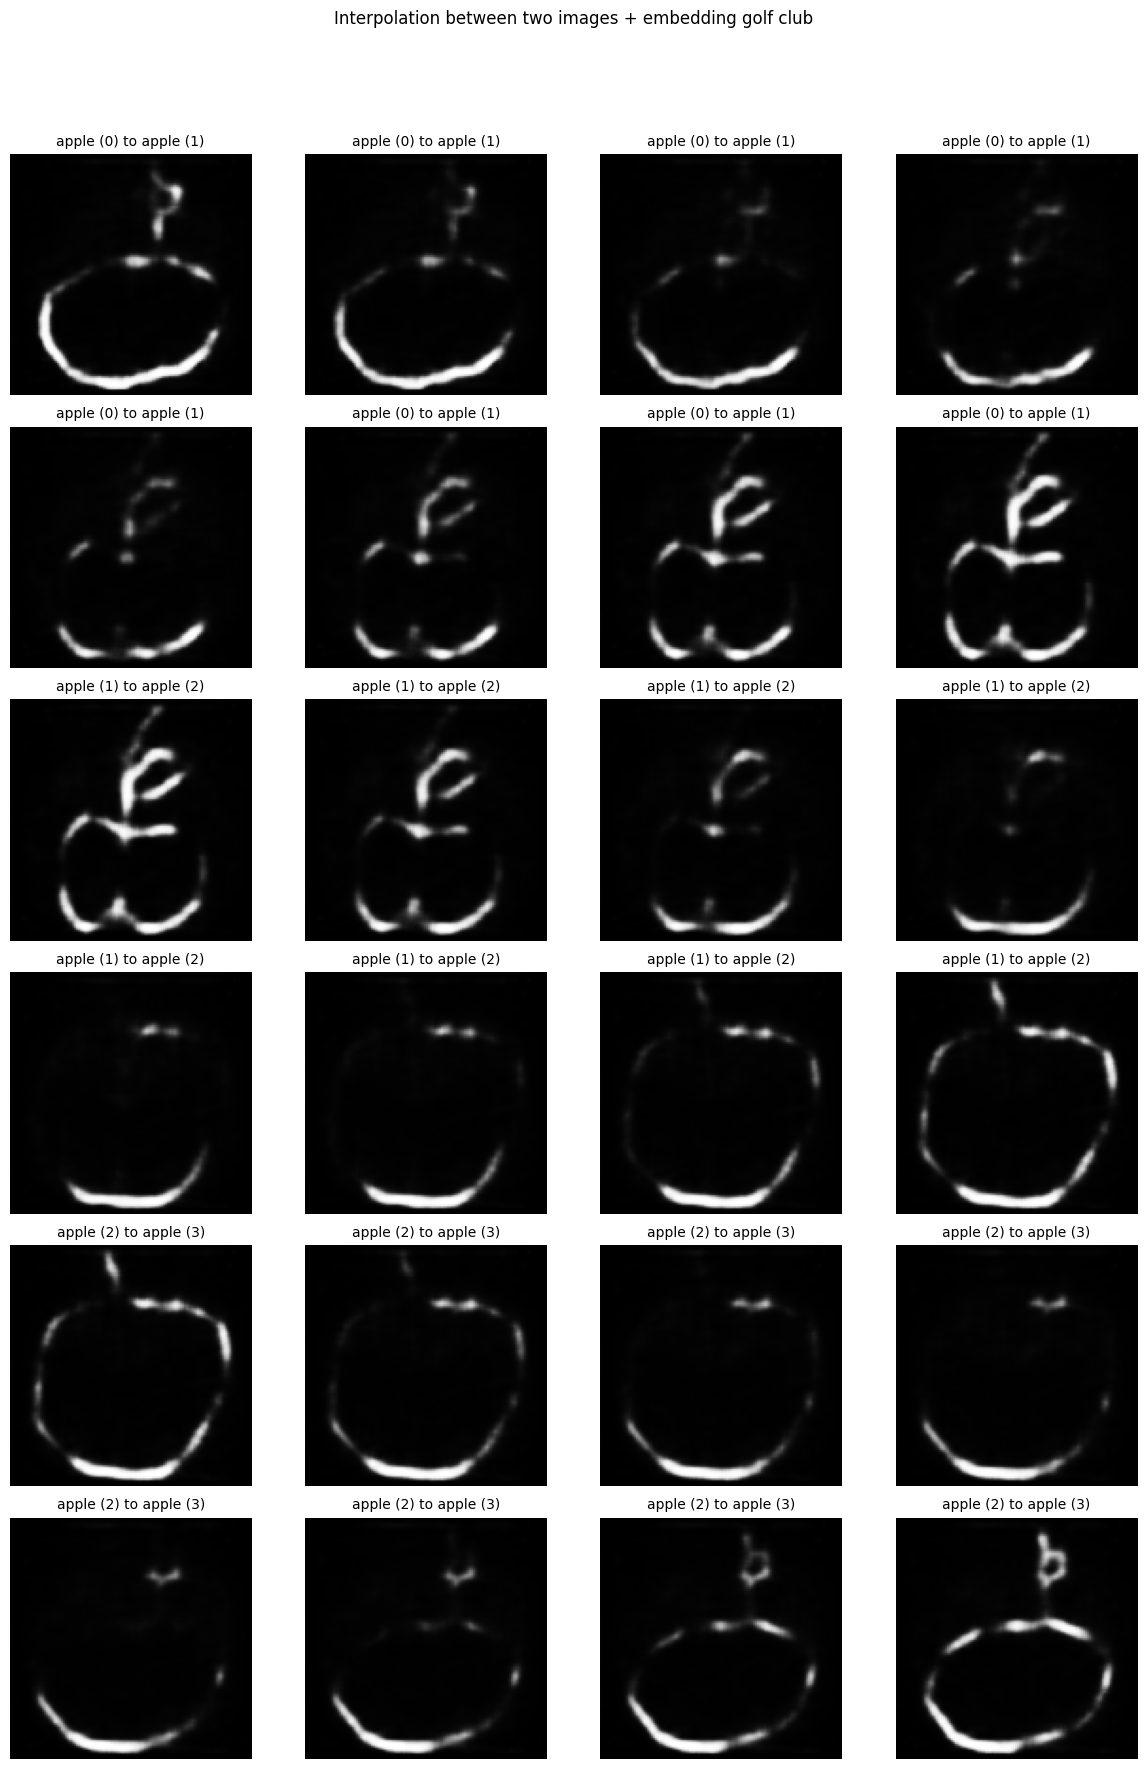

In [30]:
if is_embed_model:

    images, image_labels, image_indices = DatasetUtils.get_n_first_for_label(training_set, label_1, n_images)

    # take randomly another label without being the same as label_1
    other_label = random.randint(0, nb_classes - 1)
    other_labels = []

    images.append(images[0])
    image_labels.append(image_labels[0])
    image_indices.append(image_indices[0])

    encoded = []
    titles = []

    with torch.no_grad():
        for i in range(len(images)):
            if i < len(images) - 1:
                for j in range(interpolation):
                    titles.append(f"{classes[image_labels[i]]} ({i}) to {classes[image_labels[i + 1]]} ({i + 1})")

            pack = autoencoder_model(PytorchUtils.numpy_to_tensor(images[i], device).unsqueeze(0), torch.tensor(image_labels[i]).to(device).unsqueeze(0))
            encoded.append(pack['encoded'])

            other_labels.append(other_label)


        images = image_generator.interpolate_vectors(encoded, 
                                                    interpolation_number=interpolation, 
                                                    save_path="results/n_to_m_embed_other/", 
                                                    image_size=(None if autoencoder_model.latent_type == "convolutional" else (WIDTH, HEIGHT)),
                                                    labels=other_labels)

        image_generator.show_generated_images(images, 
                                            title="Interpolation between two images + embedding " + str(classes[other_label]),
                                            titles=titles)